In [ ]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import norm

In [ ]:
# comment out if using jupyter directly from system
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# directory from your google drive to include data and other excel files.
import os
os.chdir('/content/drive/My Drive/AOP_Final_Project')

In [ ]:
def SABRMilstein(alpha, beta, rho, F0, vol0, T, m):
    dt = T/m
    F = np.zeros(m+1)
    vol = np.zeros(m+1)
    W = np.random.normal(0, np.sqrt(dt), m)
    Z = rho * W + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), m)

    F[0] = F0
    vol[0] = vol0

    for i in range(m):
        F[i+1] = F[i] + vol[i]*F[i]**beta*W[i] + 0.5*vol[i]*vol[i]*F[i]**(2*beta)*(W[i]*W[i] - dt)
        vol[i+1] = vol[i] + alpha*vol[i]*Z[i] + 0.5*alpha*alpha*vol[i]*(Z[i]*Z[i] - dt)                #Milstein discretization based on Glasserman 2003

    return F, vol

# Parameters for SABR model
alpha = 0.1
beta = 1
rho = 0.25
F0 = 100
vol0 = 0.2
T = 1
m = 1000

F, vol = SABRMilstein(alpha, beta, rho, F0, vol0, T, m)

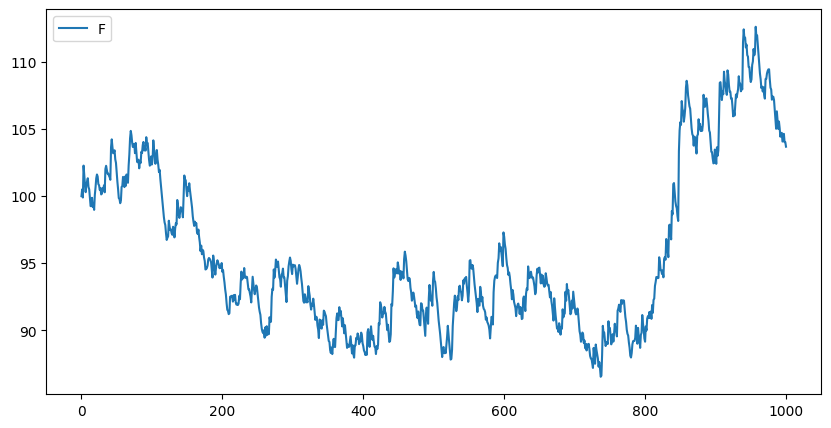

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(F, label="F")
plt.legend()
plt.show()

In [ ]:
def sabr_implied_vol_beta_1(alpha, rho, nu, F, K, T):
    z = nu/alpha * np.log(F / K) ##eq (2.17b)
    x = np.log((np.sqrt(1 - 2*rho*z + z**2) + z - rho) / (1 - rho)) ##eq (2.17c)
    y = (1 + ((rho*alpha*nu/4 + ((2 - 3*rho**2)*nu**2)/24) * T))
    implied_vol = alpha * y * (z / x) ##eq (2.17a)
    return implied_vol

In [ ]:
# Black-Scholes Call Option Price Formula
def BlackScholesCall(F, K, vol, T):
    d1 = (np.log(F / K) + (0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    call_price = F * norm.cdf(d1) - K * norm.cdf(d2)
    return call_price

def SABRMonteCarloMilsteinHagan(alpha, beta, rho, F0, vol0, T, m, n, K):
    prices = np.zeros(n)
    for i in range(n):
        F, vol = SABRMilstein(alpha, beta, rho, F0, vol0, T, m)
        imp_vol = sabr_implied_vol_beta_1(vol0, rho, alpha, F0, F[m], T)     ###since we are using a different parameterization.
        prices[i] = BlackScholesCall(F[m], K, imp_vol, T)
    return np.mean(prices)

# Parameters for SABR model
alpha = 0.1
beta = 1
rho = 0.25
F0 = 100
vol0 = 0.2
T = 1
m = 1000
n = 10000
K = 105

option_price = SABRMonteCarloMilsteinHagan(alpha, beta, rho, F0, vol0, T, m, n, K)
print('The option price using Hagan\'s approach is', option_price)

The option price using Hagan's approach is 9.899040200741828


In [ ]:
def SABRMonteCarloMilsteinCVPilotHagan(alpha, beta, rho, F0, vol0, T, m, n, K):
    # Run a small pilot Monte Carlo simulation
    pilot_n = 1000  # Number of paths for the pilot simulation
    pilot_prices = np.zeros(pilot_n)
    for i in range(pilot_n):
        F, vol = SABRMilstein(alpha, beta, rho, F0, vol0, T, m)
        imp_vol = sabr_implied_vol_beta_1(vol0, rho, alpha, F0, F[m], T)
        pilot_prices[i] = BlackScholesCall(F[m], K, imp_vol, T)

    # Estimate the expected price from the pilot simulation
    pilot_price_expected = np.mean(pilot_prices)

    prices = np.zeros(n)
    control_variate = np.zeros(n)

    for i in range(n):
        F, vol = SABRMilstein(alpha, beta, rho, F0, vol0, T, m)
        imp_vol = sabr_implied_vol_beta_1(vol0, rho, alpha, F0, F[m], T)
        prices[i] = BlackScholesCall(F[m], K, imp_vol, T)
        control_variate[i] = prices[i] - pilot_price_expected

    # Calculate the mean price and control variate
    price_mean = np.mean(prices)
    control_variate_mean = np.mean(control_variate)

    # Variance reduction using control variates
    cov = np.cov(prices, control_variate)

    # Calculate the optimal constant for the control variate        ##based on Glasserman 2003
    c = cov[0, 1] / np.var(control_variate)

    # Adjust each price using the control variate
    prices_cv = prices - c * (control_variate - control_variate_mean)

    # Calculate the mean of the adjusted prices
    price_mean_cv = np.mean(prices_cv)

    return price_mean_cv

# Parameters for SABR model
alpha = 0.1
beta = 1
rho = 0.25
F0 = 100
vol0 = 0.2
T = 1
m = 1000
n = 10000
K = 105

# Run the Monte Carlo simulation
result = SABRMonteCarloMilsteinCVPilotHagan(alpha, beta, rho, F0, vol0, T, m, n, K)
print("Option price using SABR model with control variates and Hagan's approach: ", result)

Option price using SABR model with control variates and Hagan's approach:  9.7127985970471


In [ ]:
def SABRMonteCarloMilsteinCVHagan(alpha, beta, rho, F0, vol0, imp_vol, T, m, n, K):
    # Calculate the Black-Scholes expected price
    BS_price_expected = BlackScholesCall(F0, K, imp_vol, T)

    prices = np.zeros(n)
    control_variate = np.zeros(n)

    for i in range(n):
        F, vol = SABRMilstein(alpha, beta, rho, F0, vol0, T, m)
        imp_vol_path = sabr_implied_vol_beta_1(vol0, rho, alpha, F0, F[m], T)
        prices[i] = BlackScholesCall(F[m], K, imp_vol_path, T)
        control_variate[i] = prices[i] - BS_price_expected

    # Calculate the mean price and control variate
    price_mean = np.mean(prices)
    control_variate_mean = np.mean(control_variate)

    # Variance reduction using control variates
    cov = np.cov(prices, control_variate)

    # Calculate the optimal constant for the control variate
    c = cov[0, 1] / np.var(control_variate)

    # Adjust each price using the control variate
    prices_cv = prices - c * (control_variate - control_variate_mean)

    # Calculate the mean of the adjusted prices
    price_mean_cv = np.mean(prices_cv)

    return price_mean_cv

# Parameters for SABR model
alpha = 0.1
beta = 1
rho = 0.25
F0 = 100
vol0 = 0.2
T = 1
m = 1000
n = 10000
K = 105

imp_vol = sabr_implied_vol_beta_1(vol0, rho, alpha, F0, K, T)  ###since we are using a different parameterization.

# Run the Monte Carlo simulation
result = SABRMonteCarloMilsteinCVHagan(alpha, beta, rho, F0, vol0, imp_vol, T, m, n, K)
print("Option price using SABR model with control variates BS control: ", result)

Option price using SABR model with control variates BS control:  10.005813059850544


In [ ]:
def SABRMilsteinAV(alpha, beta, rho, F0, vol0, T, m, W, Z):
    dt = T/m
    F = np.zeros(m+1)
    vol = np.zeros(m+1)
    W = np.random.normal(0, np.sqrt(dt), m)
    Z = rho * W + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(dt), m)

    F[0] = F0
    vol[0] = vol0

    for i in range(m):
        F[i+1] = F[i] + vol[i]*F[i]**beta*W[i] + 0.5*vol[i]*vol[i]*F[i]**(2*beta)*(W[i]*W[i] - dt)
        vol[i+1] = vol[i] + alpha*vol[i]*Z[i] + 0.5*alpha*alpha*vol[i]*(Z[i]*Z[i] - dt)

    return F, vol

In [ ]:
def SABRMonteCarloMilsteinAVHagan(alpha, beta, rho, F0, vol0, T, m, n, K):
    option_prices = np.zeros(n)

    for i in range(n):
        W = np.random.normal(0, np.sqrt(T/m), m)
        Z = rho * W + np.sqrt(1 - rho**2) * np.random.normal(0, np.sqrt(T/m), m)

        F_pos, vol_pos = SABRMilsteinAV(alpha, beta, rho, F0, vol0, T, m, W, Z)
        F_neg, vol_neg = SABRMilsteinAV(alpha, beta, rho, F0, vol0, T, m, -W, -Z)

        # Calculate the implied volatilities
        imp_vol_pos = sabr_implied_vol_beta_1(vol_pos[-1], rho, alpha, F0, K, T)
        imp_vol_neg = sabr_implied_vol_beta_1(vol_neg[-1], rho, alpha, F0, K, T)

        # Compute the option prices
        option_price_pos = BlackScholesCall(F_pos[-1], K, imp_vol_pos, T)
        option_price_neg = BlackScholesCall(F_neg[-1], K, imp_vol_neg, T)
        option_prices[i] = 0.5 * (option_price_pos + option_price_neg)

    return np.mean(option_prices)

# Parameters for SABR model
alpha = 0.1
beta = 1
rho = 0.25
F0 = 100
vol0 = 0.2
T = 1
m = 1000
n = 10000
K = 105

# Compute the option price
option_price = SABRMonteCarloMilsteinAVHagan(alpha, beta, rho, F0, vol0, T, m, n, K)

# Print the result
print(f"The option price with antithetic variates is: {option_price}")


The option price with antithetic variates is: 9.775646108727504


In [ ]:
# Number of Monte Carlo simulations to run
simulations = 100

price_results = np.zeros(simulations)

for i in tqdm(range(simulations)):
    price_results[i] = SABRMonteCarloMilsteinHagan(alpha, beta, rho, F0, vol0, T, m, n, K)

print("Standard deviation without variance reduction: ", np.std(price_results))

100%|██████████| 100/100 [1:19:24<00:00, 47.64s/it]

Standard deviation without variance reduction:  0.12671733750045838


In [ ]:
# ### Save results   ###UNCOMMENT IF RUNNING FROM SCRATCH
# import pickle
# with open('option_prices_no_var_red.obj', 'wb') as file:
#   pickle.dump(price_results, file)

In [ ]:
simulations = 100

price_results_CV = np.zeros(simulations)

for i in tqdm(range(simulations)):
    price_results_CV[i] = SABRMonteCarloMilsteinCVPilotHagan(alpha, beta, rho, F0, vol0, T, m, n, K)

print("Standard deviation with control variates: ", np.std(price_results_CV))

100%|██████████| 100/100 [1:28:22<00:00, 53.03s/it]

Standard deviation with control variates:  0.12702060330304873


In [ ]:
# ### Save results
# with open('option_prices_cv.obj', 'wb') as file:
#   pickle.dump(price_results_CV, file)

In [ ]:
simulations = 100

price_results_AV = np.zeros(simulations)

for i in tqdm(range(simulations)):
    price_results_AV[i] = SABRMonteCarloMilsteinAVHagan(alpha, beta, rho, F0, vol0, T, m, n, K)

print("Standard deviation with antithetic variates: ", np.std(price_results_AV))

100%|██████████| 100/100 [2:40:11<00:00, 96.11s/it]

Standard deviation with antithetic variates:  0.09421174572705994


In [ ]:
# ### Save results

# import pickle
# with open('option_prices_av.obj', 'wb') as file:
#   pickle.dump(price_results_AV, file)

In [ ]:
simulations = 100

price_results_CV_BS = np.zeros(simulations)

for i in tqdm(range(simulations)):
    price_results_CV_BS[i] = SABRMonteCarloMilsteinCVHagan(alpha, beta, rho, F0, vol0, imp_vol, T, m, n, K)

print("Standard deviation with control variates BS: ", np.std(price_results_CV_BS))

100%|██████████| 100/100 [1:20:03<00:00, 48.04s/it]

Standard deviation with control variates BS:  0.14250569851056816


In [ ]:
price_results_CV_BS

array([10.14004306,  9.67362556, 10.02946129,  9.65510418,  9.77813833,
        9.80877274,  9.85787496,  9.87976439,  9.94306247, 10.02121646,
        9.7730187 ,  9.82752082,  9.98897159,  9.84351589,  9.80355619,
       10.11206601,  9.82666225,  9.96876779,  9.65682162,  9.76430822,
        9.72965799,  9.82019493,  9.52413023,  9.91458999,  9.64359784,
        9.73162588, 10.02625919,  9.91446264,  9.9240508 ,  9.7687747 ,
        9.76312079,  9.59651499,  9.91654973,  9.84940494,  9.71612729,
        9.91078534,  9.79843231,  9.78632851,  9.61396614,  9.78557052,
        9.9052002 ,  9.90019382,  9.72338997, 10.07957253,  9.84145782,
        9.58807626,  9.69782021,  9.70814623, 10.1186678 ,  9.75214178,
        9.86364977,  9.91631088, 10.21904464,  9.88448727, 10.0241633 ,
       10.057073  ,  9.69625651,  9.98937706,  9.84670796,  9.88753323,
        9.64086132,  9.76718581,  9.80547832,  9.87380726,  9.87708167,
        9.90385779,  9.9690311 ,  9.7401349 ,  9.58408147, 10.12

In [ ]:
import pickle

In [ ]:
# with open('option_prices_cv_bs.obj', 'wb') as file:
#   pickle.dump(price_results_CV_BS, file)

In [ ]:
with open('option_prices_no_var_red.obj', 'rb') as file:
    results_no_var_red = pickle.load(file)

np.std(results_no_var_red)

0.12671733750045838

In [ ]:
with open('option_prices_cv.obj', 'rb') as file:
    results_cv_pilot = pickle.load(file)

np.std(results_cv_pilot)

0.12702060330304873

In [ ]:
with open('option_prices_cv_bs.obj', 'rb') as file:
    results_cv_bs_control = pickle.load(file)

np.std(results_cv_bs_control)

0.14250569851056816

In [ ]:
with open('option_prices_av.obj', 'rb') as file:
    results_av_best = pickle.load(file)

np.std(results_av_best)

0.09421174572705994

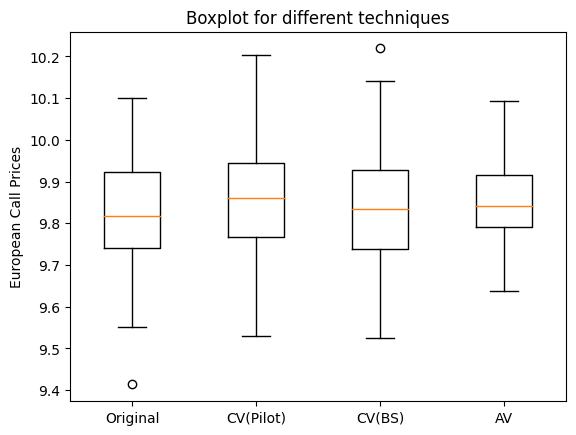

In [ ]:
import matplotlib.pyplot as plt

# Let's assume you have three arrays
array1 = results_no_var_red
array2 = results_cv_pilot
array3 = results_cv_bs_control
array4 = results_av_best
# Create the boxplot
plt.boxplot([array1, array2, array3, array4], labels=['Original', 'CV(Pilot)', 'CV(BS)', 'AV'])
plt.ylabel('European Call Prices')  # Label for y-axis
plt.title('Boxplot for different techniques')  # Title of the plot
plt.show()  # Display the plot